In [1]:
import fastf1 as ff1
import pandas as pd

In [2]:
import os

cache_dir = "path_to_cache"
os.makedirs(cache_dir, exist_ok=True)
ff1.Cache.enable_cache(cache_dir)

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']


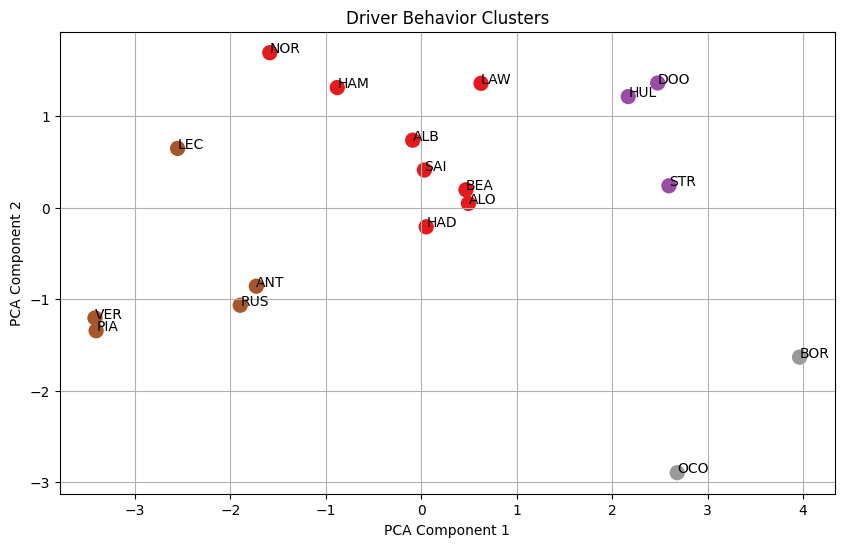

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load a race session
race = ff1.get_session(2025, 'Saudi Arabian Grand Prix', 'R')

race.load(laps=True)

# Get all laps
laps = race.laps.pick_quicklaps().reset_index()

# Convert time columns to seconds
laps['Time'] = laps['Time'].dt.total_seconds()
laps['LapTime'] = laps['LapTime'].dt.total_seconds()
laps['Sector1Time'] = laps['Sector1Time'].dt.total_seconds()
laps['Sector2Time'] = laps['Sector2Time'].dt.total_seconds()
laps['Sector3Time'] = laps['Sector3Time'].dt.total_seconds()

# Clean missing data
laps = laps.dropna(subset=['Sector1Time', 'Sector2Time', 'Sector3Time'])

# Calculate position change per lap (overtake score)
laps['PositionChange'] = laps.groupby('Driver')['Position'].diff().fillna(0)
laps['PositionChangeAbs'] = laps['PositionChange'].abs()

# Aggregate per driver
driver_stats = []

for driver in laps['Driver'].unique():
    driver_laps = laps[laps['Driver'] == driver]
    
    # Skip drivers with very few laps
    if len(driver_laps) < 5:
        continue
        
    stats = {
        'Driver': driver,
        'AvgLapTime': driver_laps['LapTime'].mean(),
        'StdLapTime': driver_laps['LapTime'].std(),
        'AvgS1': driver_laps['Sector1Time'].mean(),
        'AvgS2': driver_laps['Sector2Time'].mean(),
        'AvgS3': driver_laps['Sector3Time'].mean(),
        'StintLength': driver_laps.groupby('Stint').size().max(),  # Longest stint
        'OvertakeScore': driver_laps['PositionChangeAbs'].sum(),   # Total position changes
        'PitStopCount': driver_laps['PitOutTime'].notnull().sum()  # Number of pit stops
    }
    driver_stats.append(stats)

# Create DataFrame
driver_df = pd.DataFrame(driver_stats)

# Drop drivers with missing values
driver_df = driver_df.dropna()

# Normalize features
features = ['AvgLapTime', 'StdLapTime', 'AvgS1', 'AvgS2', 'AvgS3', 'StintLength', 'OvertakeScore', 'PitStopCount']
X = driver_df[features]
X_scaled = StandardScaler().fit_transform(X)

# Cluster drivers
kmeans = KMeans(n_clusters=4, random_state=42)
driver_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=driver_df['Cluster'], cmap='Set1', s=100)
for i, driver in enumerate(driver_df['Driver']):
    plt.text(reduced[i, 0], reduced[i, 1], driver)
plt.title("Driver Behavior Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os

# Define year
year = 2025

# Get all events in the season

schedule1 = ff1.get_event_schedule(year)
events = schedule1[['EventName', 'EventDate']].to_dict('records')


# Create output directories
os.makedirs(f"pca_plots/{year}", exist_ok=True)
os.makedirs(f"pca_results/{year}", exist_ok=True)

print(f"Starting PCA visualization for {year} races...\n")

# Loop through all events
for event in events:
    event_name = event['EventName'].strip()
    event_date = event['EventDate']
    
    print(f"🔄 Processing: {event_name} ({event_date})")
    
    try:
        # Load race session
        session = ff1.get_session(year, event_name, 'R')
        session.load(telemetry=False, laps=True)
        
        # Get laps
        laps = session.laps.pick_quicklaps().reset_index()
        
        # Convert time columns to seconds
        laps['LapTime'] = laps['LapTime'].dt.total_seconds()
        laps['Sector1Time'] = laps['Sector1Time'].dt.total_seconds()
        laps['Sector2Time'] = laps['Sector2Time'].dt.total_seconds()
        laps['Sector3Time'] = laps['Sector3Time'].dt.total_seconds()
        
        # Clean missing data
        laps = laps.dropna(subset=['Sector1Time', 'Sector2Time', 'Sector3Time'])
        
        # Calculate position change (overtake score)
        laps['PositionChange'] = laps.groupby('Driver')['Position'].diff().fillna(0)
        laps['PositionChangeAbs'] = laps['PositionChange'].abs()
        
        # Aggregate per driver
        driver_stats = []
        
        for driver in laps['Driver'].unique():
            driver_laps = laps[laps['Driver'] == driver]
            
            if len(driver_laps) < 2:
                continue  # Allow drivers with at least 2 laps
                
            stats = {
                'Driver': driver,
                'AvgLapTime': driver_laps['LapTime'].mean(),
                'StdLapTime': driver_laps['LapTime'].std(),
                'AvgS1': driver_laps['Sector1Time'].mean(),
                'AvgS2': driver_laps['Sector2Time'].mean(),
                'AvgS3': driver_laps['Sector3Time'].mean(),
                'StintLength': driver_laps.groupby('Stint').size().max(),
                'OvertakeScore': driver_laps['PositionChangeAbs'].sum(),
                'PitStopCount': driver_laps['PitOutTime'].notnull().sum()
            }
            driver_stats.append(stats)
        
        if not driver_stats:
            print(f"  ⚠️ No valid drivers found for {event_name}")
            continue
            
        driver_df = pd.DataFrame(driver_stats)
        driver_df = driver_df.dropna()
        
        if len(driver_df) < 4:
            print(f"  ⚠️ Not enough drivers ({len(driver_df)}) for clustering in {event_name}")
            continue
        
        # Normalize features
        features = ['AvgLapTime', 'StdLapTime', 'AvgS1', 'AvgS2', 'AvgS3', 'StintLength', 'OvertakeScore', 'PitStopCount']
        X = driver_df[features]
        X_scaled = StandardScaler().fit_transform(X)
        
        # PCA
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(X_scaled)
        
        # KMeans Clustering
        kmeans = KMeans(n_clusters=4, random_state=42)
        driver_df['Cluster'] = kmeans.fit_predict(X_scaled)
        
        # Add PCA components for plotting
        driver_df['PCA1'] = reduced[:, 0]
        driver_df['PCA2'] = reduced[:, 1]
        
        # Save CSV
        driver_df.to_csv(f"pca_results/{year}/{event_name.replace(' ', '_')}.csv", index=False)
        
        # Generate and save plot
        plt.figure(figsize=(10, 6))
        plt.scatter(reduced[:, 0], reduced[:, 1], c=driver_df['Cluster'], cmap='Set1', s=100)
        
        # Label each driver
        for i, driver in enumerate(driver_df['Driver']):
            plt.text(reduced[i, 0], reduced[i, 1], driver, fontsize=9)
            
        plt.title(f"{event_name} - Driver Behavior Clusters")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.grid(True)
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f"pca_plots/{year}/{event_name.replace(' ', '_')}.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"  ✅ Processed {len(driver_df)} drivers for {event_name}")
        
    except Exception as e:
        print(f"  ❌ Failed to process {event_name}: {str(e)}")
        continue

print("\n📊 All PCA visualizations completed!")
print(f"Check the 'pca_plots/{year}' folder for individual race plots")
print(f"Check 'pca_results/{year}' for CSV data files")

events      WARNING 	Correcting user input 'Pre-Season Testing' to 'Singapore Grand Prix'
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


Starting PCA visualization for 2025 races...

🔄 Processing: Pre-Season Testing (2025-02-28 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Pre-Season Testing: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Australian Grand Prix (2025-03-16 00:00:00)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  ✅ Processed 13 drivers for Australian Grand Prix
🔄 Processing: Chinese Grand Prix (2025-03-23 00:00:00)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['PositionChange'] = laps.groupby('Driver')['Position'].diff().fillna(0)
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

  ✅ Processed 20 drivers for Chinese Grand Prix
🔄 Processing: Japanese Grand Prix (2025-04-06 00:00:00)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '44', '6', '23', '87', '14', '22', '10', '55', '7', '27', '30', '31', '5', '18']
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['PositionChange'] = laps.groupby('Driver')['Position'].diff().fillna(0)
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

  ✅ Processed 20 drivers for Japanese Grand Prix
🔄 Processing: Bahrain Grand Prix (2025-04-13 00:00:00)


core        WARNING 	Driver 63: Lap timing integrity check failed for 3 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['PositionChange'] = laps.groupby('Driver')['Position'].diff().fillna(0)
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

  ✅ Processed 20 drivers for Bahrain Grand Prix
🔄 Processing: Saudi Arabian Grand Prix (2025-04-20 00:00:00)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  ✅ Processed 18 drivers for Saudi Arabian Grand Prix
🔄 Processing: Miami Grand Prix (2025-05-04 00:00:00)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '23', '12', '16', '44', '55', '22', '6', '31', '10', '27', '14', '18', '30', '5', '87', '7']
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['PositionChange'] = laps.groupby('Driver')['Position'].diff().fillna(0)
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

  ✅ Processed 19 drivers for Miami Grand Prix
🔄 Processing: Emilia Romagna Grand Prix (2025-05-18 00:00:00)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '44', '23', '16', '63', '55', '6', '22', '14', '27', '10', '30', '18', '43', '87', '5', '12', '31']
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['PositionChange'] = laps.groupby('Driver')['Position'].diff().fillna(0)
C:\Users\2003y\AppData\Local\Temp\ipykernel_1116\3964832342.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

  ✅ Processed 20 drivers for Emilia Romagna Grand Prix
🔄 Processing: Monaco Grand Prix (2025-05-25 00:00:00)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


  ✅ Processed 19 drivers for Monaco Grand Prix
🔄 Processing: Spanish Grand Prix (2025-06-01 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Spanish Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Canadian Grand Prix (2025-06-15 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Canadian Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Austrian Grand Prix (2025-06-29 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Austrian Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: British Grand Prix (2025-07-06 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process British Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Belgian Grand Prix (2025-07-27 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Belgian Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Hungarian Grand Prix (2025-08-03 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Hungarian Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Dutch Grand Prix (2025-08-31 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Dutch Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Italian Grand Prix (2025-09-07 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Italian Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Azerbaijan Grand Prix (2025-09-21 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Azerbaijan Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Singapore Grand Prix (2025-10-05 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Singapore Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: United States Grand Prix (2025-10-19 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process United States Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Mexico City Grand Prix (2025-10-26 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Mexico City Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: São Paulo Grand Prix (2025-11-09 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process São Paulo Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Las Vegas Grand Prix (2025-11-22 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Las Vegas Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Qatar Grand Prix (2025-11-30 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Qatar Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
🔄 Processing: Abu Dhabi Grand Prix (2025-12-07 00:00:00)


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ Failed to process Abu Dhabi Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`

📊 All PCA visualizations completed!
Check the 'pca_plots/2025' folder for individual race plots
Check 'pca_results/2025' for CSV data files


In [12]:
print("Number of laps loaded:", len(race.laps))
print("Lap columns:", race.laps.columns)

Number of laps loaded: 1252
Lap columns: Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')


In [8]:
cluster_labels = {
    0: "Aggressive",
    1: "Consistent",
    2: "Strategic",
    3: "High-Speed"
}
driver_df['ClusterLabel'] = driver_df['Cluster'].map(cluster_labels)

In [12]:



import glob

# Load all race data for 2025
all_files = glob.glob("pca_results/2025/*.csv")
dfs = [pd.read_csv(f) for f in all_files]
full_df = pd.concat(dfs, ignore_index=True)

# Define cluster labels
cluster_labels = {
    0: "Aggressive Overtakers",
    1: "Consistent Pacers",
    2: "Strategic Long-Stinters",
    3: "High-Speed Specialists"
}

# Count how often each driver appears in each cluster
season_summary = full_df.groupby(['Driver', 'Cluster']).size().unstack(fill_value=0)

# Rename columns using the cluster labels
season_summary = season_summary.rename(columns=cluster_labels)

# Ensure all cluster columns exist (in case some clusters are missing)
for label in cluster_labels.values():
    if label not in season_summary.columns:
        season_summary[label] = 0

# Reorder columns to match cluster order
season_summary = season_summary[cluster_labels.values()]

# Save to CSV
season_summary.to_csv("driver_cluster_summary_2025.csv")

print(season_summary)

Cluster  Aggressive Overtakers  Consistent Pacers  Strategic Long-Stinters  \
Driver                                                                       
ALB                          6                  0                        0   
ALO                          3                  1                        2   
ANT                          1                  0                        5   
BEA                          4                  1                        0   
BOR                          1                  5                        0   
COL                          0                  1                        0   
DOO                          2                  2                        0   
GAS                          3                  0                        2   
HAD                          4                  1                        1   
HAM                          3                  2                        2   
HUL                          2                  3               